In [3]:
#10/26/20
#THIS SCRIPT WILL MAKE INTEGRATED SEURAT OBJECT WITH STANDARD WORKFLOW, WITHOUT PROTOPLAST INDUCED 
#GENES, OR MITO/CP GENES IN THE VARIABLE FEATURE LIST. ALSO TAKE OUT LOW QUALITY GENES (THOSE WITH MT > 10%), AND PUTATIVE
#DOUBLETS.
#THIS INTEGRATES WT AND MUTANT

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
if (!requireNamespace("here", quietly = TRUE))
    install.packages("here")
if (!requireNamespace("ggplot2", quietly = TRUE))
    install.packages("ggplot2")
if (!requireNamespace("ggpointdensity", quietly = TRUE))
    install.packages("ggpointdensity")
if (!requireNamespace("DropletUtils", quietly = TRUE)) 
    BiocManager::install("DropletUtils")
if (!requireNamespace("BUSpaRse", quietly = TRUE)) 
    BiocManager::install("BUSpaRse")
if (!requireNamespace("scico", quietly = TRUE))
    install.packages("scico")
if (!requireNamespace("reticulate", quietly = TRUE))
    install.packages("reticulate")
if (!requireNamespace("future", quietly = TRUE))
    install.packages("future")
if (!requireNamespace("DoubletFinder", quietly = TRUE))
    remotes::install_github('chris-mcginnis-ucsf/DoubletFinder')
if (!requireNamespace("tidyverse", quietly = TRUE))
    install.packages("tidyverse")
#devtools::install_github(repo = 'satijalab/seurat', ref = 'develop')
# if (!requireNamespace("COPILOT", quietly = TRUE))
#     devtools::install_github('Hsu-Che-Wei/COPILOT')

In [ ]:
library(BUSpaRse)
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scico)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
library(DoubletFinder)
library(future)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 4,]$genes)

In [12]:
wt_1_seu = readRDS(file = "../data/seurat5/wt_1_ED_scrub_min_features_mito.rds")
wt_2_seu = readRDS(file = "../data/seurat5/wt_2_ED_scrub_min_features_mito.rds")
mut_1_seu = readRDS(file = "../data/seurat5/mut_1_ED_scrub_min_features_mito.rds")
mut_2_seu = readRDS(file = "../data/seurat5/mut_2_ED_scrub_min_features_mito.rds")

In [ ]:
#check distribution of UMIs per barcode
thr = 500
sum(colSums(wt_1_seu@assays$RNA@counts) > thr)
sum(colSums(wt_2_seu@assays$RNA@counts) > thr)
sum(colSums(mut_1_seu@assays$RNA@counts) > thr)
sum(colSums(mut_2_seu@assays$RNA@counts) > thr)

In [ ]:
#Perform SCTransform
defaultW <- getOption("warn") 
options(warn = -1) 
wt_1_seu = SCTransform(wt_1_seu, verbose = FALSE)
wt_2_seu = SCTransform(wt_2_seu, verbose = FALSE)
mut_1_seu = SCTransform(mut_1_seu, verbose = FALSE)
mut_2_seu = SCTransform(mut_2_seu, verbose = FALSE)
options(warn = defaultW)

In [ ]:
saveRDS(wt_1_seu, "/home/robotmessenger810/sc_analysis/data/intd_seu_objects/individual_SCT_10_13_20/wt_1_SCT.rds")
saveRDS(wt_2_seu, "/home/robotmessenger810/sc_analysis/data/intd_seu_objects/individual_SCT_10_13_20/wt_2_SCT.rds")
saveRDS(mut_1_seu, "/home/robotmessenger810/sc_analysis/data/intd_seu_objects/individual_SCT_10_13_20/mut_1_SCT.rds")
saveRDS(mut_2_seu, "/home/robotmessenger810/sc_analysis/data/intd_seu_objects/individual_SCT_10_13_20/mut_2_SCT.rds")

In [3]:
wt_1_seu = readRDS("/home/robotmessenger810/sc_analysis/data/intd_seu_objects/individual_SCT_10_13_20/wt_1_SCT.rds")
wt_2_seu = readRDS("/home/robotmessenger810/sc_analysis/data/intd_seu_objects/individual_SCT_10_13_20/wt_2_SCT.rds")
mut_1_seu = readRDS("/home/robotmessenger810/sc_analysis/data/intd_seu_objects/individual_SCT_10_13_20/mut_1_SCT.rds")
mut_2_seu = readRDS("/home/robotmessenger810/sc_analysis/data/intd_seu_objects/individual_SCT_10_13_20/mut_2_SCT.rds")

In [ ]:
all_intd_sct = seu_integrate(wt_1_seu, wt_2_seu, mut_1_seu, mut_2_seu, filename = "std_intd_all_7_SCT_mt_removed_minus_protos_mt_cp", nfeatures = 3000)

In [1]:
all_intd_sct = readRDS("../data/intd_seu_objects/std_intd_all_7_SCT_mt_removed_minus_protos_mt_cp.rds")

In [3]:
DefaultAssay(all_intd_sct) <- "RNA"
all_intd_sct = NormalizeData(all_intd_sct, verbose = FALSE)

In [8]:
DefaultAssay(all_intd_sct) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
all_intd_sct <- RunPCA(all_intd_sct, npcs = 30, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

In [9]:
all_intd_sct <- FindNeighbors(all_intd_sct, dims = 1:30)
all_intd_sct <- FindClusters(all_intd_sct, resolution = 0.5)
all_intd_sct <- RunUMAP(all_intd_sct, reduction = "pca", dims = 1:30)

16:12:23 Writing NN index file to temp file /tmp/RtmpHTC62g/file256c3b5a34d6

16:12:23 Searching Annoy index using 1 thread, search_k = 3000

16:12:39 Annoy recall = 100%

16:12:40 Commencing smooth kNN distance calibration using 1 thread

16:12:43 Initializing from normalized Laplacian + noise

16:12:45 Commencing optimization for 200 epochs, with 1370054 positive edges

16:13:36 Optimization finished



    
     SeuratProject
  0           3819
  1           2987
  2           2866
  3           2784
  4           2633
  5           2496
  6           2137
  7           1880
  8           1806
  9           1554
  10          1542
  11          1385
  12          1296
  13          1240
  14          1098
  15           514
  16           504
  17           454
  18           117

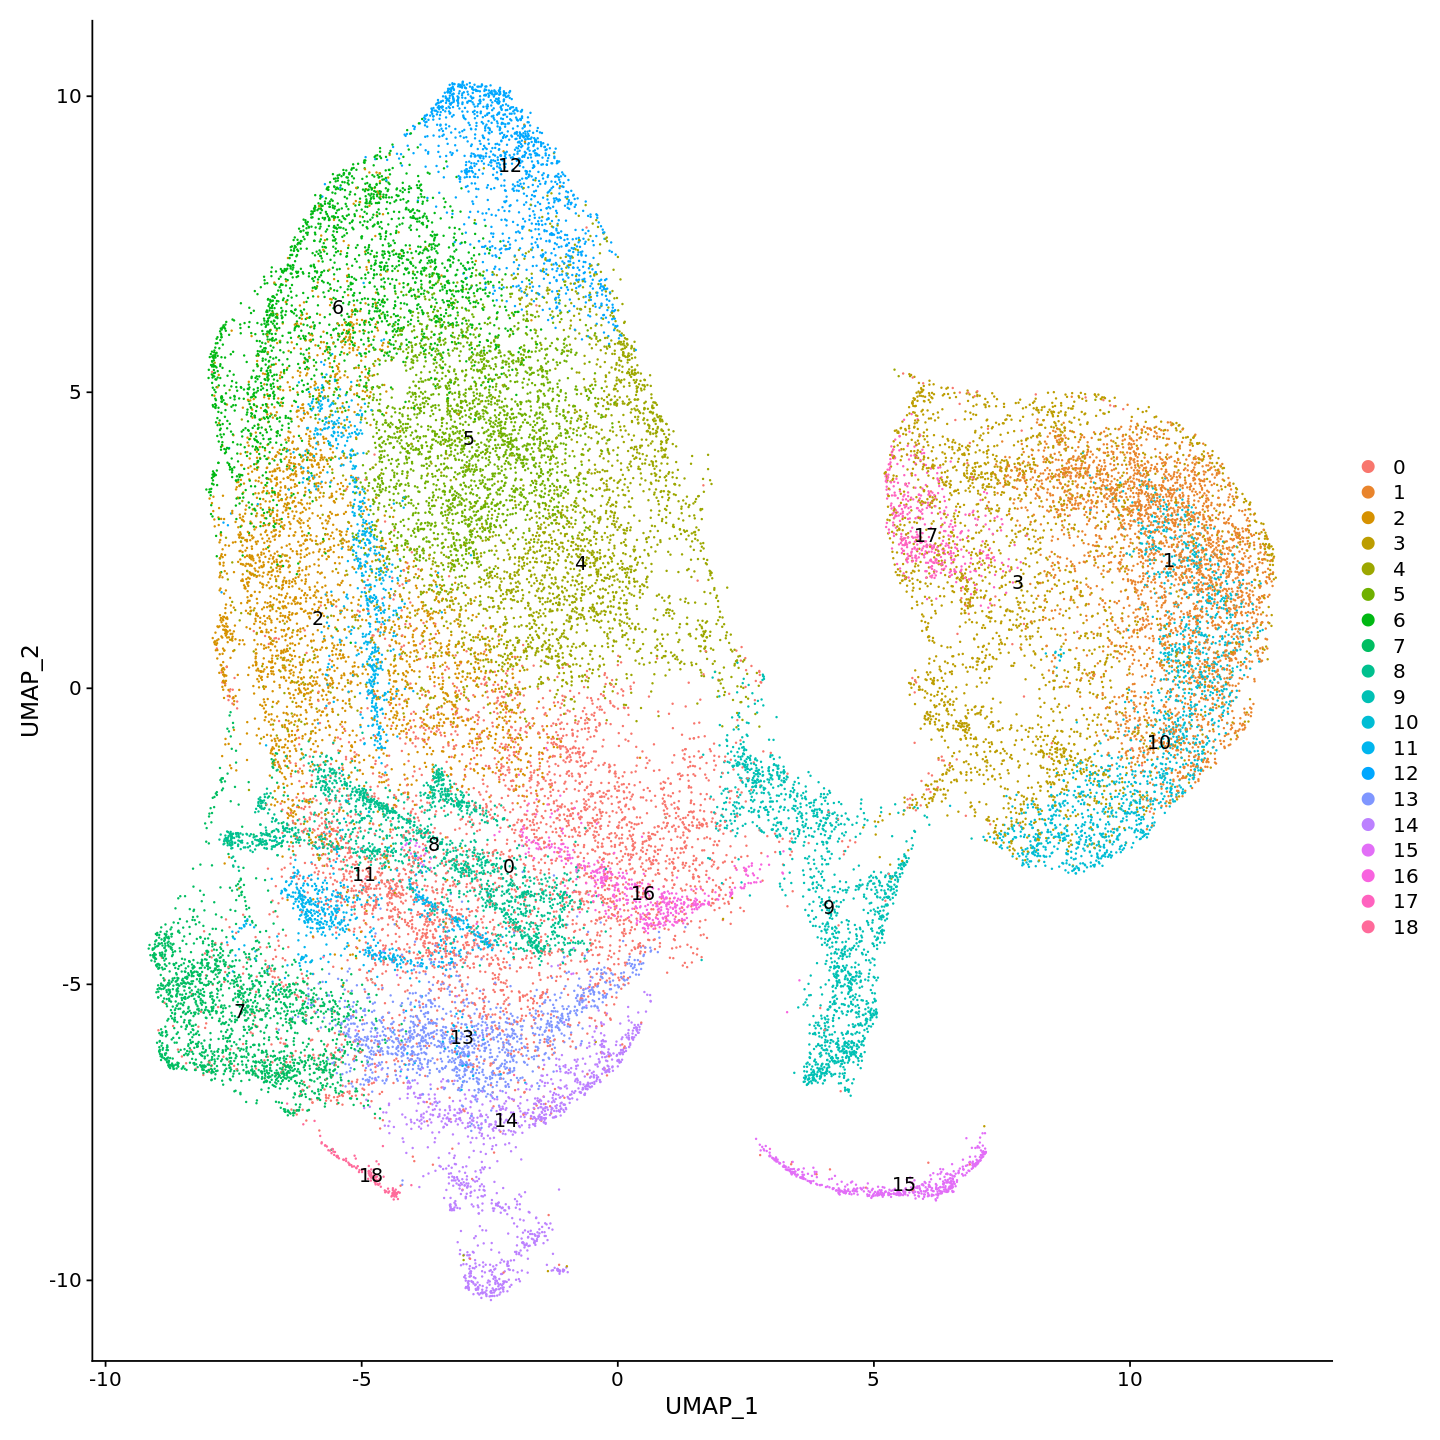

In [10]:
DimPlot(all_intd_sct, reduction = "umap", label = TRUE)

table(Idents(all_intd_sct), all_intd_sct$orig.ident)

In [13]:
#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
all_intd_sct@meta.data$orig.ident = c(rep("WT_1",length(colnames(wt_1_seu@assays$RNA))), rep("WT_2",length(colnames(wt_2_seu@assays$RNA))), rep("MUT_1",length(colnames(mut_1_seu@assays$RNA))), rep("MUT_2",length(colnames(mut_2_seu@assays$RNA))))
all_intd_sct@meta.data$orig.geno = c(rep("WT",length(colnames(wt_1_seu@assays$RNA)) + length(colnames(wt_2_seu@assays$RNA))), rep("MUT",length(colnames(mut_1_seu@assays$RNA)) + length(colnames(mut_2_seu@assays$RNA))))

In [ ]:
#test resolution
all_intd_sct_resolution_test = list()
all_markers = list()

for (i in c(1:5)) {
    all_intd_sct_resolution_test[[i]] <- FindClusters(all_intd_sct, resolution = (i)/10)
    #all_intd_sct_resolution_test[[i]] <- RunUMAP(all_intd_sct_resolution_test[[i]], reduction = "pca", dims = 1:10)
    all_markers[[i]] <- FindAllMarkers(all_intd_sct_resolution_test[[i]], min.pct =  0.25, min.diff.pct = 0.25)
}

In [14]:
saveRDS(all_intd_sct, "../data/intd_seu_objects/intd_normalized_etc_11_12_20_30pcs.rds")

In [ ]:
#takes a list of Seurat objects with SCT transform run
seu_integrate <- function(..., filename, nfeatures){
    seu.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    ref.genes = rownames(seu.list[[1]]@assays$RNA)
    assay_list <- rep("SCT", length(seu.list))
    # loop
    for (i in 1:length(seu.list)) {
        seu.list[[i]]@assays$spliced_RNA <- NULL
        seu.list[[i]]@assays$spliced_SCT <- NULL
        seu.list[[i]]@assays$unspliced_RNA <- NULL
        seu.list[[i]]@assays$unspliced_SCT <- NULL
        

    # integration
    rc.features <- SelectIntegrationFeatures(object.list = seu.list, nfeatures = nfeatures)
    rc.features <- rc.features[(!c(grepl("ATMG",rc.features) | grepl("ATCG",rc.features) | rc.features%in%proto_list))]
    
    seu.list <- PrepSCTIntegration(object.list = seu.list, anchor.features = rc.features, verbose = TRUE, assay = assay_list)
    seu.list <- lapply(X = seu.list, FUN = RunPCA, verbose = FALSE, features = rc.features)
    rc.anchors <- FindIntegrationAnchors(object.list = seu.list, normalization.method = "SCT", anchor.features = rc.features, verbose = TRUE, reference=1, reduction = "rpca")
    
    to_integrate <- Reduce(intersect, lapply(rc.anchors@object.list, rownames))
    # integrate data and keep full geneset
       
    rc.integrated <- IntegrateData(anchorset = rc.anchors,  features.to.integrate = to_integrate, normalization.method = "SCT", verbose = TRUE)
    rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
    }
}